# Retriever Evaluation Tutorial

In MLflow 2.8.0, we introduced a new model type "retriever" to the `mlflow.evaluate()` API. It helps you to evaluate the retriever in a RAG application. It contains two built-in metrics `precision_at_k` and `recall_at_k`. In MLflow 2.9.0, `ndcg_at_k` is available.

This notebook illustrates how to use `mlflow.evaluate()` to evaluate the retriever in a RAG application. It has the following steps:

* Step 1: Install and Load Packages
* Step 2: Evaluation Dataset Preparation
* Step 3: Calling `mlflow.evaluate()`
* Step 4: Result Analysis and Visualization

## Step 1: Install and Load Packages

In [ ]:
%pip install mlflow==2.9.0 langchain==0.0.339 openai faiss-cpu gensim nltk pyLDAvis tiktoken

In [1]:
import ast
import os
import pprint
from typing import List

import pandas as pd
from langchain.docstore.document import Document
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS

import mlflow

os.environ["OPENAI_API_KEY"] = "<redacted>"

CHUNK_SIZE = 1000

# Assume running from https://github.com/mlflow/mlflow/blob/master/examples/llms/rag
OUTPUT_DF_PATH = "question_answer_source.csv"
SCRAPPED_DOCS_PATH = "mlflow_docs_scraped.csv"
EVALUATION_DATASET_PATH = "static_evaluation_dataset.csv"
DB_PERSIST_DIR = "faiss_index"

## Step 2: Evaluation Dataset Preparation
The evaluation dataset should contain three columns: questions, ground truth doc IDs, retrieved relevant doc IDs. A "doc ID" is a unique string identifier of the documents in you RAG application. For example, it could be the URL of a documentation web page, or the file path of a PDF document.

If you have a list of questions that you would like to evaluate, please see 1.1 Manual Preparation. If you do not have a question list yet, please see 1.2 Generate the Evaluation Dataset.


### Manual Preparation

When evaluating a retriever, it's recommended to save the retrieved document IDs into a static dataset represented by a Pandas Dataframe or an MLflow Pandas Dataset containing the input queries, retrieved relevant document IDs, and the ground-truth document IDs for the evaluation.

#### Concepts

A "document ID" is a string that identifies a document.

A list of "retrieved relevant document IDs" are the output of the retriever for a specific input query and a `k` value.

A list of "ground-truth document IDs" are the labeled relevant documents for a specific input query.

#### Expected Data Format

For each row, the retrieved relevant document IDs and the ground-truth relevant document IDs should be provided as a tuple of document ID strings.

The column name of the retrieved relevant document IDs should be specified by the `predictions` parameter, and the column name of the ground-truth relevant document IDs should be specified by the `targets` parameter.

Here is a simple example dataset that illustrates the expected data format. The doc IDs are the paths of the documentation pages.

In [ ]:
data = pd.DataFrame(
    {
        "questions": [
            "What is MLflow?",
            "What is Databricks?",
            "How to serve a model on Databricks?",
            "How to enable MLflow Autologging for my workspace by default?",
        ],
        "retrieved_context": [
            [
                "mlflow/index.html",
                "mlflow/quick-start.html",
            ],
            [
                "introduction/index.html",
                "getting-started/overview.html",
            ],
            [
                "machine-learning/model-serving/index.html",
                "machine-learning/model-serving/model-serving-intro.html",
            ],
            [],
        ],
        "ground_truth_context": [
            ["mlflow/index.html"],
            ["introduction/index.html"],
            [
                "machine-learning/model-serving/index.html",
                "machine-learning/model-serving/llm-optimized-model-serving.html",
            ],
            ["mlflow/databricks-autologging.html"],
        ],
    }
)

### Generate the Evaluation Dataset
There are two steps to generate the evaluation dataset: generate questions with ground truth doc IDs and retrieve relevant doc IDs. 


#### Generate Questions with Ground Truth Doc IDs
If you don't have a list of questions to evaluate, you can generate them using LLMs. The [Question Generation Notebook](https://mlflow.org/docs/latest/llms/rag/notebooks/question-generation-retrieval-evaluation.html) provides an example way to do it. Here is the result of running that notebook.

In [5]:
generated_df = pd.read_csv(OUTPUT_DF_PATH)

In [7]:
generated_df.head(3)

,question,answer,chunk,chunk_id,source
0,What is the purpose of the MLflow Model Registry?,The purpose of the MLflow Model Registry is to...,Documentation MLflow Model Registry MLflow Mod...,0,model-registry.html
1,What is the purpose of registering a model wit...,The purpose of registering a model with the Mo...,"logged, this model can then be registered with...",1,model-registry.html
2,What can you do with registered models and mod...,"With registered models and model versions, you...",associate with registered models and model ver...,2,model-registry.html


In [8]:
# Prepare dataframe `data` with the required format
data = pd.DataFrame({})
data["question"] = generated_df["question"].copy(deep=True)
data["source"] = generated_df["source"].apply(lambda x: [x])
data.head(3)

,question,source
0,What is the purpose of the MLflow Model Registry?,[model-registry.html]
1,What is the purpose of registering a model wit...,[model-registry.html]
2,What can you do with registered models and mod...,[model-registry.html]


#### Retrieve Relevant Doc IDs

Once we have a list of questions with ground truth doc IDs from 1.1, we can collect the retrieved relevant doc IDs. In this tutorial, we use a LangChain retriever. You can plug in your own retriever as needed.

First, we build a FAISS retriever from the docs saved at https://github.com/mlflow/mlflow/blob/master/examples/llms/question_generation/mlflow_docs_scraped.csv. See the [Question Generation Notebook](https://mlflow.org/docs/latest/llms/rag/notebooks/question-generation-retrieval-evaluation.html) for how to create this csv file.

In [10]:
embeddings = OpenAIEmbeddings()

In [ ]:
scrapped_df = pd.read_csv(SCRAPPED_DOCS_PATH)
list_of_documents = [
    Document(page_content=row["text"], metadata={"source": row["source"]})
    for i, row in scrapped_df.iterrows()
]
text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=0)
docs = text_splitter.split_documents(list_of_documents)
db = FAISS.from_documents(docs, embeddings)

# Save the db to local disk
db.save_local(DB_PERSIST_DIR)

In [11]:
# Load the db from local disk
db = FAISS.load_local(DB_PERSIST_DIR, embeddings)
retriever = db.as_retriever()

In [13]:
# Test the retriever with a query
retrieved_docs = retriever.get_relevant_documents(
    "What is the purpose of the MLflow Model Registry?"
)
len(retrieved_docs)

4

After building a retriever, we define a function that takes a question string as input and returns a list of relevant doc ID strings.

In [14]:
# Define a function to return a list of retrieved doc ids
def retrieve_doc_ids(question: str) -> List[str]:
    docs = retriever.get_relevant_documents(question)
    return [doc.metadata["source"] for doc in docs]

We can store the retrieved doc IDs in the dataframe as a column "retrieved_doc_ids".

In [17]:
data["retrieved_doc_ids"] = data["question"].apply(retrieve_doc_ids)
data.head(3)

,question,source,retrieved_doc_ids
0,What is the purpose of the MLflow Model Registry?,[model-registry.html],"[model-registry.html, introduction/index.html,..."
1,What is the purpose of registering a model wit...,[model-registry.html],"[model-registry.html, models.html, introductio..."
2,What can you do with registered models and mod...,[model-registry.html],"[model-registry.html, models.html, deployment/..."


In [ ]:
# Persist the static evaluation dataset to disk
data.to_csv(EVALUATION_DATASET_PATH, index=False)

In [16]:
# Load the static evaluation dataset from disk and deserialize the source and retrieved doc ids
data = pd.read_csv(EVALUATION_DATASET_PATH)
data["source"] = data["source"].apply(ast.literal_eval)
data["retrieved_doc_ids"] = data["retrieved_doc_ids"].apply(ast.literal_eval)
data.head(3)

,question,source,retrieved_doc_ids
0,What is the purpose of the MLflow Model Registry?,[model-registry.html],"[model-registry.html, introduction/index.html,..."
1,What is the purpose of registering a model wit...,[model-registry.html],"[model-registry.html, models.html, introductio..."
2,What can you do with registered models and mod...,[model-registry.html],"[model-registry.html, models.html, deployment/..."


## Step 3: Calling `mlflow.evaluate()`

### Metrics Definition

There are three built-in metrics provided for the retriever model type. Click the metric name below to see the metrics definitions.

1.  [mlflow.metrics.precision_at_k(k)](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.precision_at_k)
1.  [mlflow.metrics.recall_at_k(k)](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.recall_at_k)
1.  [mlflow.metrics.ndcg_at_k(k)](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.ndcg_at_k) 

All metrics compute a score between 0 and 1 for each row representing the corresponding metric of the retriever model at the given `k` value.

The `k` parameter should be a positive integer representing the number of retrieved documents
to evaluate for each row. `k` defaults to 3.

When the model type is `"retriever"`, these metrics will be calculated automatically with the
default `k` value of 3.


### Basic usage

There are two supported ways to specify the retriever's output:

* Case 1: Save the retriever's output to a static evaluation dataset
* Case 2: Wrap the retriever in a function

In [ ]:
# Case 1: Evaluating a static evaluation dataset
with mlflow.start_run() as run:
    evaluate_results = mlflow.evaluate(
        data=data,
        model_type="retriever",
        targets="source",
        predictions="retrieved_doc_ids",
        evaluators="default",
    )

2023/11/22 14:39:59 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/22 14:39:59 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/11/22 14:39:59 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2023/11/22 14:39:59 INFO mlflow.models.evaluation.default_evaluator: Evaluating builtin metrics: precision_at_3
2023/11/22 14:39:59 INFO mlflow.models.evaluation.default_evaluator: Evaluating builtin metrics: recall_at_3
2023/11/22 14:39:59 INFO mlflow.models.evaluation.default_evaluator: Evaluating builtin metrics: ndcg_at_3


In [18]:
question_source_df = data[["question", "source"]]
question_source_df.head(3)

,question,source
0,What is the purpose of the MLflow Model Registry?,[model-registry.html]
1,What is the purpose of registering a model wit...,[model-registry.html]
2,What can you do with registered models and mod...,[model-registry.html]


In [ ]:
# Case 2: Evaluating a function
def retriever_model_function(question_df: pd.DataFrame) -> pd.Series:
    return question_df["question"].apply(retrieve_doc_ids)


with mlflow.start_run() as run:
    evaluate_results = mlflow.evaluate(
        model=retriever_model_function,
        data=question_source_df,
        model_type="retriever",
        targets="source",
        evaluators="default",
    )

2023/11/22 14:09:12 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/22 14:09:12 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/11/22 14:09:12 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2023/11/22 14:09:24 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2023/11/22 14:09:24 INFO mlflow.models.evaluation.default_evaluator: Evaluating builtin metrics: precision_at_3
2023/11/22 14:09:24 INFO mlflow.models.evaluation.default_evaluator: Evaluating builtin metrics: recall_at_3
2023/11/22 14:09:24 INFO mlflow.models.evaluation.default_evaluator: Evaluating builtin metrics: ndcg_at_3


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(evaluate_results.metrics)

{   'ndcg_at_3/mean': 0.7530888125490431,
    'ndcg_at_3/p90': 1.0,
    'ndcg_at_3/variance': 0.1209151911325433,
    'precision_at_3/mean': 0.26785714285714285,
    'precision_at_3/p90': 0.3333333333333333,
    'precision_at_3/variance': 0.017538265306122448,
    'recall_at_3/mean': 0.8035714285714286,
    'recall_at_3/p90': 1.0,
    'recall_at_3/variance': 0.15784438775510204}


### Try different k values
To use another `k` value, use the `evaluator_config` parameter
in the `mlflow.evaluate()` API as follows: `evaluator_config={"retriever_k": <k_value>}`.


```python
# Case 1: Specifying the model type
evaluate_results = mlflow.evaluate(
    data=data,
    model_type="retriever",
    targets="ground_truth_context",
    predictions="retrieved_context",
    evaluators="default",
    evaluator_config={"retriever_k": 5}
  )
```

Alternatively, you can directly specify the desired metrics
in the `extra_metrics` parameter of the `mlflow.evaluate()` API without specifying a model
type. In this case, the `k` value specified in the `evaluator_config` parameter will be
ignored.


```python
# Case 2: Specifying the extra_metrics
evaluate_results = mlflow.evaluate(
    data=data,
    targets="ground_truth_context",
    predictions="retrieved_context",
    extra_matrics=[
      mlflow.metrics.precision_at_k(4),
      mlflow.metrics.precision_at_k(5)
    ],
  )
```

In [ ]:
with mlflow.start_run() as run:
    evaluate_results = mlflow.evaluate(
        data=data,
        targets="source",
        predictions="retrieved_doc_ids",
        evaluators="default",
        extra_metrics=[
            mlflow.metrics.precision_at_k(1),
            mlflow.metrics.precision_at_k(2),
            mlflow.metrics.precision_at_k(3),
            mlflow.metrics.recall_at_k(1),
            mlflow.metrics.recall_at_k(2),
            mlflow.metrics.recall_at_k(3),
            mlflow.metrics.ndcg_at_k(1),
            mlflow.metrics.ndcg_at_k(2),
            mlflow.metrics.ndcg_at_k(3),
        ],
    )

2023/11/22 14:40:22 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/22 14:40:22 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/11/22 14:40:22 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2023/11/22 14:40:22 INFO mlflow.models.evaluation.default_evaluator: Evaluating metrics: precision_at_1
2023/11/22 14:40:22 INFO mlflow.models.evaluation.default_evaluator: Evaluating metrics: precision_at_2
2023/11/22 14:40:22 INFO mlflow.models.evaluation.default_evaluator: Evaluating metrics: precision_at_3
2023/11/22 14:40:22 INFO mlflow.models.evaluation.default_evaluator: Evaluating metrics: recall_at_1
2023/11/22 14:40:22 INFO mlflow.models.evaluation.default_evaluator: Evaluating metrics: recall_at_2
2

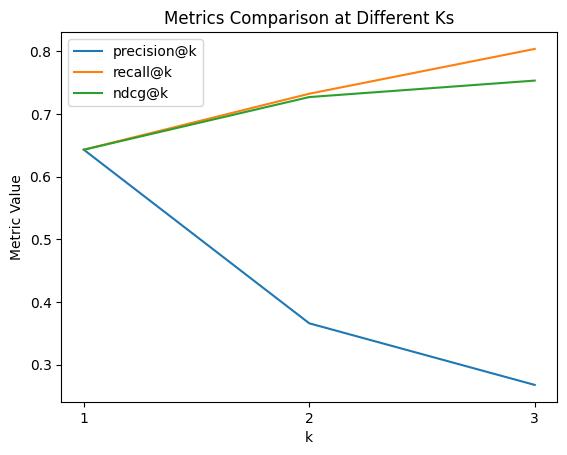

In [ ]:
import matplotlib.pyplot as plt

# Plotting each metric
for metric_name in ["precision", "recall", "ndcg"]:
    y = [evaluate_results.metrics[f"{metric_name}_at_{k}/mean"] for k in range(1, 4)]
    plt.plot([1, 2, 3], y, label=f"{metric_name}@k")

# Adding labels and title
plt.xlabel("k")
plt.ylabel("Metric Value")
plt.title("Metrics Comparison at Different Ks")
# Setting x-axis ticks
plt.xticks([1, 2, 3])
plt.legend()

# Display the plot
plt.show()

### Corner case handling

There are a few corner cases handle specially for each built-in metric.

#### Empty retrieved document IDs

When no relevant docs are retrieved:

- `mlflow.metrics.precision_at_k(k)` is defined as:
  * 0 if the ground-truth doc IDs is non-empty
  * 1 if the ground-truth doc IDs is also empty

- `mlflow.metrics.ndcg_at_k(k)` is defined as:
  * 0 if the ground-truth doc IDs is non-empty
  * 1 if the ground-truth doc IDs is also empty

#### Empty ground-truth document IDs

When no ground-truth document IDs are provided:

- `mlflow.metrics.recall_at_k(k)` is defined as:
  * 0 if the retrieved doc IDs is non-empty
  * 1 if the retrieved doc IDs is also empty

- `mlflow.metrics.ndcg_at_k(k)` is defined as:
  * 0 if the retrieved doc IDs is non-empty
  * 1 if the retrieved doc IDs is also empty

#### Duplicate retreived document IDs

It is a common case for the retriever in a RAG system to retrieve multiple chunks in the same document for a given query. In this case, `mlflow.metrics.ndcg_at_k(k)` is calculated as follows:

If the duplicate doc IDs are in the ground truth,
       they will be treated as different docs. For example, if the ground truth doc IDs are
       [1, 2] and the retrieved doc IDs are [1, 1, 1, 3], the score will be equavalent to
       ground truth doc IDs [10, 11, 12, 2] and retrieved doc IDs [10, 11, 12, 3].

If the duplicate doc IDs are not in the ground truth, the ndcg score is calculated as normal.

## Step 4: Result Analysis and Visualization

You can view the per-row scores in the logged "eval_results_table.json" in artifacts by either loading it to a pandas dataframe (shown below) or visiting the MLflow run comparison UI.

In [ ]:
eval_results_table = evaluate_results.tables["eval_results_table"]
eval_results_table.head(5)

,question,source,retrieved_doc_ids,precision_at_1/score,precision_at_2/score,precision_at_3/score,recall_at_1/score,recall_at_2/score,recall_at_3/score,ndcg_at_1/score,ndcg_at_2/score,ndcg_at_3/score
0,What is the purpose of the MLflow Model Registry?,[model-registry.html],"[model-registry.html, introduction/index.html,...",1,0.5,0.333333,1,1,1,1,1.0,0.919721
1,What is the purpose of registering a model wit...,[model-registry.html],"[model-registry.html, models.html, introductio...",1,0.5,0.333333,1,1,1,1,1.0,1.000000
2,What can you do with registered models and mod...,[model-registry.html],"[model-registry.html, models.html, deployment/...",1,0.5,0.333333,1,1,1,1,1.0,1.000000
3,"How can you add, modify, update, or delete a m...",[model-registry.html],"[model-registry.html, models.html, deployment/...",1,0.5,0.333333,1,1,1,1,1.0,1.000000
4,How can you deploy and organize models in the ...,[model-registry.html],"[model-registry.html, deployment/index.html, d...",1,0.5,0.333333,1,1,1,1,1.0,0.919721


With the evaluate results table, you can further visualize the well-answered questions and poorly-answered questions using topical analysis techniques.

In [ ]:
import nltk
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Initialize NLTK resources
nltk.download("punkt")
nltk.download("stopwords")


def topical_analysis(questions: List[str]):
    stop_words = set(stopwords.words("english"))

    # Tokenize and remove stop words
    tokenized_data = []
    for question in questions:
        tokens = word_tokenize(question.lower())
        filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
        tokenized_data.append(filtered_tokens)

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(tokenized_data)
    corpus = [dictionary.doc2bow(text) for text in tokenized_data]

    # Apply LDA model
    lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Get topic distribution for each question
    topic_distribution = []
    for i, ques in enumerate(questions):
        bow = dictionary.doc2bow(tokenized_data[i])
        topics = lda_model.get_document_topics(bow)
        topic_distribution.append(topics)
        print(f"Question: {ques}\nTopic: {topics}")

    # Print all topics
    print("\nTopics found are:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic: {idx} \nWords: {topic}\n")
    return lda_model, corpus, dictionary

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liang.zhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liang.zhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filtered_df = eval_results_table[eval_results_table["precision_at_1/score"] == 1]
hit_questions = filtered_df["question"].tolist()
filtered_df = eval_results_table[eval_results_table["precision_at_1/score"] == 0]
miss_questions = filtered_df["question"].tolist()

In [ ]:
lda_model, corpus, dictionary = topical_analysis(hit_questions)
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

Question: What is the purpose of the MLflow Model Registry?
Topic: [(0, 0.0400703), (1, 0.040002838), (2, 0.040673085), (3, 0.04075462), (4, 0.8384991)]
Question: What is the purpose of registering a model with the Model Registry?
Topic: [(0, 0.0334267), (1, 0.033337697), (2, 0.033401005), (3, 0.033786207), (4, 0.8660484)]
Question: What can you do with registered models and model versions?
Topic: [(0, 0.04019648), (1, 0.04000775), (2, 0.040166058), (3, 0.8391777), (4, 0.040452003)]
Question: How can you add, modify, update, or delete a model in the Model Registry?
Topic: [(0, 0.025052568), (1, 0.025006149), (2, 0.025024023), (3, 0.025236268), (4, 0.899681)]
Question: How can you deploy and organize models in the Model Registry?
Topic: [(0, 0.033460867), (1, 0.033337582), (2, 0.033362914), (3, 0.8659808), (4, 0.033857808)]
Question: What method do you use to create a new registered model?
Topic: [(0, 0.028867528), (1, 0.028582651), (2, 0.882546), (3, 0.030021703), (4, 0.029982116)]
Que

In [3]:
# Uncomment the following line to render the interactive widget
# pyLDAvis.display(vis_data)

In [ ]:
lda_model, corpus, dictionary = topical_analysis(miss_questions)
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

Question: What is the purpose of the mlflow.sklearn.log_model() method?
Topic: [(0, 0.0669118), (1, 0.06701085), (2, 0.06667974), (3, 0.73235476), (4, 0.06704286)]
Question: How can you fetch a specific model version?
Topic: [(0, 0.83980393), (1, 0.040003464), (2, 0.04000601), (3, 0.040101767), (4, 0.040084846)]
Question: How can you fetch the latest model version in a specific stage?
Topic: [(0, 0.88561153), (1, 0.028575428), (2, 0.028578365), (3, 0.0286214), (4, 0.028613236)]
Question: What can you do to promote MLflow Models across environments?
Topic: [(0, 0.8661927), (1, 0.0333396), (2, 0.03362743), (3, 0.033428304), (4, 0.033411972)]
Question: What is the name of the model and its version details?
Topic: [(0, 0.83978903), (1, 0.04000637), (2, 0.04001106), (3, 0.040105395), (4, 0.040088095)]
Question: What is the purpose of saving the model in pickled format?
Topic: [(0, 0.033948876), (1, 0.03339717), (2, 0.033340737), (3, 0.86575514), (4, 0.033558063)]
Question: What is an MLflow

In [4]:
# Uncomment the following line to render the interactive widget
# pyLDAvis.display(vis_data)